# Density simulation of a McKean-Vlasov SDE with linear interaction

This notebook implements the simulations described in Section 3.1 of

- Hoffmann, M. and Liu, Y (2023). A statistical approach for simulating the density solution of a McKean-Vlasov equation.

-------------------------------

**Contents**

* [1. Definition of the McKean-Vlasov equation, the particle system and the Euler scheme](#chapter1)

* [2. Density simulation with Gaussian-based high order Kernels](#chapter2)

    * [2.1 Definition of Gaussian-based high order Kernels](#section2-1)
    
    * [2.2 Gaussian Kernel ( Kernel Order = 1 )](#section2-2)
    
    * [2.3 Kernel Order = 3](#section2-3)
    
    * [2.4 Kernel Order = 5](#section2-4)
    
    * [2.5 Kernel Order = 7](#section2-5)
    
    * [2.6 Kernel Order = 9](#section2-6)
    
    * [2.7 Comparison of simulation results with different kernels](#section2-7)

-------------------------------

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

import pandas as pd
from scipy.stats import norm
from sklearn.linear_model import LinearRegression

## 1. Definition of the McKean-Vlasov equation, the particle system and the Euler scheme <a class="anchor" id="chapter1"></a>


We consider a stochastic process $(X_t)_{t\in[0, T]}$ defined by the following McKean-Vlasov SDE with linear interaction

$$dX_t = - \int_{\mathbb{R}}(X_t-x)\mu_t(dx)dt+dB_t\quad \text{with}\quad X_0\sim \mathcal{N}(3, \frac{1}{2}),\hspace{2cm}(1)$$

where for every  $t\in[0,T]$, $\mu_t$ denotes the probability distrubtion of $X_t$.  This process $(X_t)_{t\in[0, T]}$ is a stationary Ornstein-Uhlenbeck process, namely, for every $t\in[0,T], \; \mu_t=\mathcal{N}(3, \frac{1}{2})$.

Let $N$ be the number of particles. The $N$-particle system $(X_t^{1}, ..., X_t^{N})_{t\in[0,T]}$ corresponding to Equation (1) is defined as follows :


\begin{equation}
dX_t^{n}=- \frac{1}{N} \sum_{i=1}^{N}\big(X_t^{n}-X_t^{i}\big) dt+\sigma B_t^{n}.\hspace{2cm}(2)
\end{equation}

Let $M$ denote the time discretization number for the Euler scheme. Set $h=\frac{T}{M}$ and $t_m=m\cdot h, 0\leq m\leq M$. Combining the particle system (2) and the Euler scheme, we obtain the following discrete particle system :

\begin{equation}
X^{n}_{t_{m+1}}=X^{n}_{t_{m}}+h\cdot  \frac{1}{N}\sum_{i=1}^{N}\Big(X_{t_m}^{i}-X_{t_m}^{n}\Big)+\sqrt{h} Z_{m+1}^{n},\quad 1\leq n\leq N,
\end{equation}
where $ \: Z_{m+1}^{n}:=\frac{1}{\sqrt{h}}(B^n_{t_{m+1}}-B^n_{t_{m}})$ are i.i.d random variables having the standard normal distribution $\mathcal{N}(0,1)$.

* In this notebook, we fix $T=1$ and $M=100$.

In [ ]:
# Parameters

T=1.
M=100  # Time discretization number
h=T/M  # Time step

m_X0=3  # Mean of the distribution of X_0

In the next cell, the function `Euler_one_step` defines the operator of the Euler scheme for one time step.

In [ ]:
def Euler_one_step(X_in,N_in):
    nn=np.ones(N_in)/N_in
    EXin=np.dot(nn,X_in)
    X_out=X_in+h*(EXin-X_in)+np.sqrt(h)*np.random.normal(0, 1, N_in)
    return X_out

We consider different particle numbers : $N\in\{2^7=128, 2^8=256, ..., 2^{15}=32768\}$.

In [ ]:
pn=9
N_power=np.linspace(7,15,pn)
print (N_power)

N_vec=2**N_power.astype(int) # Number of particles, from 2^7 to 2^15
print (N_vec)

[ 7.  8.  9. 10. 11. 12. 13. 14. 15.]
[  128   256   512  1024  2048  4096  8192 16384 32768]


First, we compute and save the particle systems at time T=1 with different particle numbers in `N_vec`. For each given particle number, we implement 30 identical and independent simulations.

In [ ]:
# Number of identical and independent simulations

NNs=30

for i in tqdm(range(pn)):
    for nns in range(NNs):
        particle_process=np.zeros((N_vec[i],M))
        particle_process[:,0]=np.random.normal(m_X0, np.sqrt(1/2), N_vec[i])

        for m in range(M-1):
            particle_process[:,m+1]=Euler_one_step(particle_process[:,m],N_vec[i])

        np.savetxt("particle_num_"+str(N_vec[i])+"repeat"+str(nns)+".csv", particle_process[:,-1], delimiter=",")


100%|█████████████████████████████████████████████| 9/9 [00:25<00:00,  2.78s/it]


The following cell defines the true density function of $X_t$, for every $t\in[0,T]$, which is the density function of the normal distribution $\mathcal{N}(3,\frac{1}{2})$.

In [ ]:
# Definition of the true density function

def density_true(x_in):
    return norm.pdf(x_in,m_X0,np.sqrt(1/2))


-------------------


# 2. Density simulation with Gaussian-based high order Kernel <a class="anchor" id="chapter2"></a>

In this section, we simulate the density of $X_t$ with the optimal bandwidth choice defined in Corollary 2.11 of [Hoffmann, M. and Liu, Y (2023)]

$$\eta_{\text{opt}}=N^{-\frac{1}{2(l+1)+1}},$$

where $N$ is the number of particles and $l$ is the order of the Kernel. The error $\mathbb{E}\Big[\,\big|\,\widehat{\mu}_T^{N, h, \eta}(x)-\mu_T(x)\,\big|^2\Big]$ is approximated by

$$\varepsilon_N=\frac{1}{30}\sum_{j=1}^{30}\max_{x\in\mathcal{D}}\Big|\;\big(\widehat{\mu}_T^{N, h, \eta}\big)_j(x)-\mu_T(x)\;\Big|^{\,2},$$

where $\big(\widehat{\mu}_T^{N, h, \eta}\big)_j, \, 1\leq j\leq 30$ are simulated density functions based on the above 30 independent particle systems and the domain $\mathcal{D}$ is a uniform grid of 1000 points in [0,6].

## 2.1 Definition of Gaussian-based high order kernel <a class="anchor" id="section2-1"></a>



The Gaussian-based high order kernels that we use in this notebook are
- Order 1 : $\phi(x)=\frac{1}{\sqrt{2\pi}}\exp\big(-\frac{x^2}{2}\big)$



- Order 3 : $\frac{1}{2}(3-x^2)\,\phi(x)$



- Order 5 : $\frac{1}{8}(15-10x^2+x^4)\,\phi(x)$



- Order 7 : $\frac{1}{48}(105-105x^2+21x^4-x^6)\,\phi(x)$



- Order 9 : $\frac{1}{384}(945-1260x^2+378x^4-36x^6+x^8)\,\phi(x)$


which are defined in the following paper (see Table 1):

- Wand, Matthew P., and William R. Schucany. "Gaussian‐based kernels." Canadian Journal of Statistics 18, no. 3 (1990): 197-204.



In [ ]:
# Kernel order 1

def kernel_O1(x_in):
    return np.exp(-0.5*(x_in**2))/np.sqrt(2*np.pi)

kernel_O1_fun = lambda x: np.exp(-0.5*(x**2))/np.sqrt(2*np.pi)

# Kernel order 3

def kernel_O3(x_in):
    return 0.5*(3-x_in**2)*np.exp(-0.5*(x_in**2))/np.sqrt(2*np.pi)

kernel_O3_fun = lambda x: 0.5*(3-x**2)*np.exp(-0.5*(x**2))/np.sqrt(2*np.pi)

# Kernel order 5

def kernel_O5(x_in):
    return (15-10*x_in**2+x_in**4)*np.exp(-0.5*(x_in**2))/np.sqrt(2*np.pi)/8

kernel_O5_fun = lambda x: (15-10*x**2+x**4)*np.exp(-0.5*(x**2))/np.sqrt(2*np.pi)/8

# Kernel order 7

def kernel_O7(x_in):
    return (105-105*x_in**2+21*x_in**4-x_in**6)*np.exp(-0.5*(x_in**2))/np.sqrt(2*np.pi)/48

kernel_O7_fun = lambda x: (105-105*x**2+21*x**4-x**6)*np.exp(-0.5*(x**2))/np.sqrt(2*np.pi)/48

# Kernel order 9

def kernel_O9(x_in):
    return (945-1260*x_in**2+378*x_in**4-36*x_in**6+x_in**8)*np.exp(-0.5*(x_in**2))/np.sqrt(2*np.pi)/384

kernel_O9_fun = lambda x: (945-1260*x**2+378*x**4-36*x**6+x**8)*np.exp(-0.5*(x**2))/np.sqrt(2*np.pi)/384


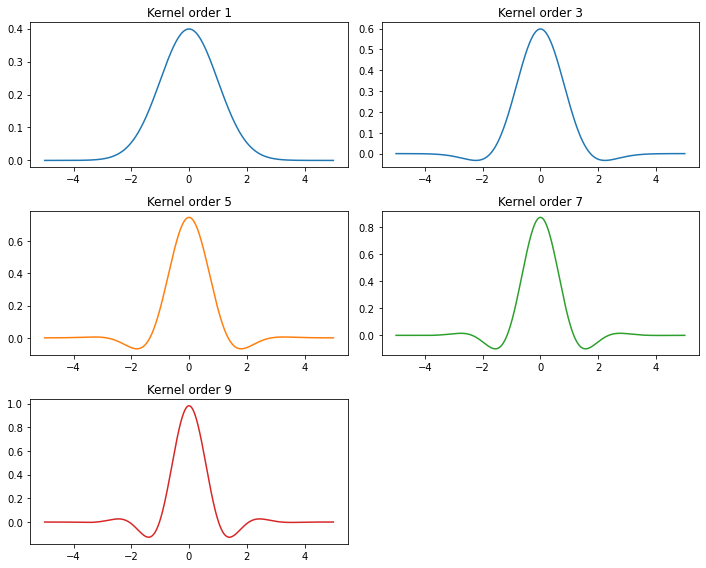

In [ ]:
test_xx=np.linspace(-5,5,1000)
Kernel_O1_plot=kernel_O1_fun(test_xx)
Kernel_O3_plot=kernel_O3_fun(test_xx)
Kernel_O5_plot=kernel_O5_fun(test_xx)
Kernel_O7_plot=kernel_O7_fun(test_xx)
Kernel_O9_plot=kernel_O9_fun(test_xx)


fig, axs = plt.subplots(3, 2, figsize=(10,8))
axs[0, 0].plot(test_xx, Kernel_O1_plot)
axs[0, 0].set_title('Kernel order 1')
axs[0, 1].plot(test_xx, Kernel_O3_plot)
axs[0, 1].set_title('Kernel order 3')
axs[1, 0].plot(test_xx, Kernel_O5_plot, 'tab:orange')
axs[1, 0].set_title('Kernel order 5')
axs[1, 1].plot(test_xx, Kernel_O7_plot, 'tab:green')
axs[1, 1].set_title('Kernel order 7')
axs[2, 0].plot(test_xx, Kernel_O9_plot, 'tab:red')
axs[2, 0].set_title('Kernel order 9')
axs[2, 1].axis('off')
fig.tight_layout()

## 2.2 Gaussian Kernel ( Kernel Order = 1 ) <a class="anchor" id="section2-2"></a>


In [ ]:

error_N_Gaussian_kernel=[]

l_regularity_plus_one=2 # l=1 then l+1=2

for i in tqdm(range(pn)):
    error=np.zeros(NNs)
    for nns in range(NNs):

        density_particle= np.array(pd.read_csv("particle_num_"+str(N_vec[i])+"repeat"+str(nns)+".csv", sep=',',header=None))

        Error_simu_number=1000

        X_simu = np.linspace(0, 6, Error_simu_number)[:, np.newaxis]

        Error_simu_vec=np.zeros(Error_simu_number)
        error_vec=np.zeros(Error_simu_number)

        eta_opt = (N_vec[i])**(-1./(2*l_regularity_plus_one+1))

        for j in range(Error_simu_number):
            Error_simu_vec[j]=kernel_O1_fun((X_simu[j]-density_particle)/eta_opt).sum()/(N_vec[i]*eta_opt) # O2!
            error_vec[j]=np.abs(Error_simu_vec[j] - density_true(X_simu[j]))

        error_one=error_vec.max()**2
        error[nns]=error_one

    print ("i=",i,";", "the number of particle is", N_vec[i],";", "The optimal bandwidth is",eta_opt, ".")
    print (i,"the error is :", error.mean())

    error_N_Gaussian_kernel.append(error.mean()) # Name of the error vector !

    np.savetxt("error_"+str(i)+"_op_Gaussian_kernel.csv", error_N_Gaussian_kernel, delimiter=",") # Name of the error vector !



 11%|█████                                        | 1/9 [00:03<00:26,  3.29s/it]

i= 0 ; the number of particle is 128 ; The optimal bandwidth is 0.3789291416275995 .
0 the error is : 0.007727871245047099


 22%|██████████                                   | 2/9 [00:06<00:23,  3.29s/it]

i= 1 ; the number of particle is 256 ; The optimal bandwidth is 0.32987697769322355 .
1 the error is : 0.0048755370423037014


 33%|███████████████                              | 3/9 [00:10<00:20,  3.36s/it]

i= 2 ; the number of particle is 512 ; The optimal bandwidth is 0.2871745887492587 .
2 the error is : 0.003764142409511425


 44%|████████████████████                         | 4/9 [00:13<00:17,  3.43s/it]

i= 3 ; the number of particle is 1024 ; The optimal bandwidth is 0.24999999999999997 .
3 the error is : 0.0017576497470290944


 56%|█████████████████████████                    | 5/9 [00:17<00:14,  3.57s/it]

i= 4 ; the number of particle is 2048 ; The optimal bandwidth is 0.217637640824031 .
4 the error is : 0.0013028398248083504


 67%|██████████████████████████████               | 6/9 [00:22<00:11,  3.97s/it]

i= 5 ; the number of particle is 4096 ; The optimal bandwidth is 0.18946457081379975 .
5 the error is : 0.0009298815737459299


 78%|███████████████████████████████████          | 7/9 [00:28<00:09,  4.60s/it]

i= 6 ; the number of particle is 8192 ; The optimal bandwidth is 0.16493848884661177 .
6 the error is : 0.0005485441748598086


 89%|████████████████████████████████████████     | 8/9 [00:36<00:05,  5.82s/it]

i= 7 ; the number of particle is 16384 ; The optimal bandwidth is 0.14358729437462936 .
7 the error is : 0.0004132562140446379


100%|█████████████████████████████████████████████| 9/9 [00:51<00:00,  5.69s/it]

i= 8 ; the number of particle is 32768 ; The optimal bandwidth is 0.12499999999999999 .
8 the error is : 0.00022798859094508623


---------------------------------------

The next cell shows the log-log error curve of the density simulation with the Gaussian kernel.

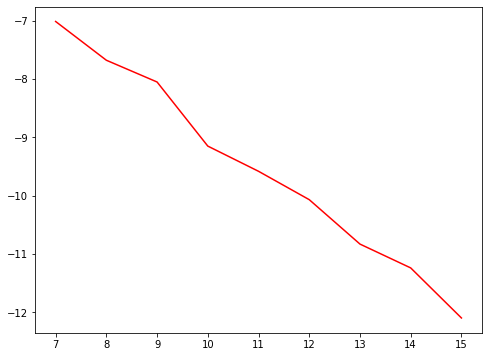

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(np.log2(N_vec),np.log2(error_N_Gaussian_kernel),"r")

The least-square estimate of the slope of the above curve is the following.

In [ ]:
X=np.log2(N_vec).reshape(-1,1)
y=np.log2(error_N_Gaussian_kernel)
reg_Gaussian = LinearRegression().fit(X, y)
print ("The estimate of the slope is", reg_Gaussian.coef_)
print ("The estimate of the intercept is", reg_Gaussian.intercept_)


The estimate of the slope is [-0.624822]
The estimate of the intercept is -2.6522754794411316


## 2.3 Kernel order = 3 <a class="anchor" id="section2-3"></a>

In [ ]:
error_N_O3_kernel=[]

l_regularity_plus_one=4  # l=1 then l+1=2

for i in tqdm(range(pn)):
    error=np.zeros(NNs)
    for nns in range(NNs):

        density_particle= np.array(pd.read_csv("particle_num_"+str(N_vec[i])+"repeat"+str(nns)+".csv", sep=',',header=None))

        Error_simu_number=1000

        X_simu = np.linspace(0, 6, Error_simu_number)[:, np.newaxis]

        Error_simu_vec=np.zeros(Error_simu_number)
        error_vec=np.zeros(Error_simu_number)

        eta_opt = (N_vec[i])**(-1./(2*l_regularity_plus_one+1))

        for j in range(Error_simu_number):
            Error_simu_vec[j]=kernel_O3_fun((X_simu[j]-density_particle)/eta_opt).sum()/(N_vec[i]*eta_opt)
            error_vec[j]=np.abs(Error_simu_vec[j] - density_true(X_simu[j]))

        error_one=error_vec.max()**2
        error[nns]=error_one

    print ("i=",i,";", "the number of particle is", N_vec[i],";", "The optimal bandwidth is",eta_opt, ".")
    print (i,"the error is :", error.mean())

    error_N_O3_kernel.append(error.mean())

    np.savetxt("error_"+str(i)+"_op_Order_3_kernel.csv", error_N_O3_kernel, delimiter=",")



 11%|█████                                        | 1/9 [00:03<00:28,  3.53s/it]

i= 0 ; the number of particle is 128 ; The optimal bandwidth is 0.5832645197880583 .
0 the error is : 0.005647156893429341


 22%|██████████                                   | 2/9 [00:06<00:24,  3.49s/it]

i= 1 ; the number of particle is 256 ; The optimal bandwidth is 0.540029869446153 .
1 the error is : 0.00331953350309303


 33%|███████████████                              | 3/9 [00:10<00:21,  3.61s/it]

i= 2 ; the number of particle is 512 ; The optimal bandwidth is 0.5 .
2 the error is : 0.002600024729804308


 44%|████████████████████                         | 4/9 [00:14<00:18,  3.71s/it]

i= 3 ; the number of particle is 1024 ; The optimal bandwidth is 0.46293735614364523 .
3 the error is : 0.0010074943823206598


 56%|█████████████████████████                    | 5/9 [00:18<00:15,  3.86s/it]

i= 4 ; the number of particle is 2048 ; The optimal bandwidth is 0.42862199142653645 .
4 the error is : 0.0007406506493796021


 67%|██████████████████████████████               | 6/9 [00:23<00:12,  4.18s/it]

i= 5 ; the number of particle is 4096 ; The optimal bandwidth is 0.3968502629920499 .
5 the error is : 0.0004892469220094351


 78%|███████████████████████████████████          | 7/9 [00:30<00:09,  4.94s/it]

i= 6 ; the number of particle is 8192 ; The optimal bandwidth is 0.3674336230688997 .
6 the error is : 0.0002705490796151823


 89%|████████████████████████████████████████     | 8/9 [00:39<00:06,  6.42s/it]

i= 7 ; the number of particle is 16384 ; The optimal bandwidth is 0.3401975000435943 .
7 the error is : 0.00019988275636077468


100%|█████████████████████████████████████████████| 9/9 [00:56<00:00,  6.27s/it]

i= 8 ; the number of particle is 32768 ; The optimal bandwidth is 0.3149802624737183 .
8 the error is : 0.00011196206288253552


---------------------------------------

The next cell shows the log-log error curve of the density simulation with the Gaussian high order kernel of order 3.

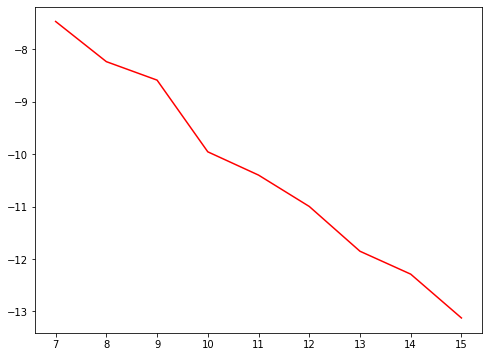

In [ ]:
plt.figure(figsize=(8,6))

plt.plot(np.log2(N_vec),np.log2(error_N_O3_kernel),"r")


The least-square estimate of the slope of the above curve is the following.

In [ ]:
X=np.log2(N_vec).reshape(-1,1)
y=np.log2(error_N_O3_kernel)
reg_Kernal_O3 = LinearRegression().fit(X, y)
print ("The estimate of the slope is", reg_Kernal_O3.coef_)
print ("The estimate of the intercept is", reg_Kernal_O3.intercept_)


The estimate of the slope is [-0.70597164]
The estimate of the intercept is -2.5572548818834813


## 2.4 Kernel order = 5 <a class="anchor" id="section2-4"></a>

In [ ]:

error_N_O5_kernel=[]

l_regularity_plus_one=6

for i in tqdm(range(pn)):
    error=np.zeros(NNs)
    for nns in range(NNs):

        density_particle= np.array(pd.read_csv("particle_num_"+str(N_vec[i])+"repeat"+str(nns)+".csv", sep=',',header=None))

        Error_simu_number=1000

        X_simu = np.linspace(0, 6, Error_simu_number)[:, np.newaxis]

        Error_simu_vec=np.zeros(Error_simu_number)
        error_vec=np.zeros(Error_simu_number)

        eta_opt = (N_vec[i])**(-1./(2*l_regularity_plus_one+1))

        for j in range(Error_simu_number):
            Error_simu_vec[j]=kernel_O5_fun((X_simu[j]-density_particle)/eta_opt).sum()/(N_vec[i]*eta_opt)
            error_vec[j]=np.abs(Error_simu_vec[j] - density_true(X_simu[j]))

        error_one=error_vec.max()**2
        error[nns]=error_one

    print ("i=",i,";", "the number of particle is", N_vec[i],";", "The optimal bandwidth is",eta_opt, ".")
    print (i,"the error is :", error.mean())

    error_N_O5_kernel.append(error.mean())

    np.savetxt("error_"+str(i)+"_op_Order_5_kernel.csv", error_N_O5_kernel, delimiter=",")



 11%|█████                                        | 1/9 [00:03<00:30,  3.82s/it]

i= 0 ; the number of particle is 128 ; The optimal bandwidth is 0.6885047255971347 .
0 the error is : 0.005775063854677463


 22%|██████████                                   | 2/9 [00:07<00:27,  3.96s/it]

i= 1 ; the number of particle is 256 ; The optimal bandwidth is 0.6527558488549048 .
1 the error is : 0.0029797800415177133


 33%|███████████████                              | 3/9 [00:12<00:24,  4.04s/it]

i= 2 ; the number of particle is 512 ; The optimal bandwidth is 0.618863142652714 .
2 the error is : 0.002384021475246508


 44%|████████████████████                         | 4/9 [00:16<00:21,  4.25s/it]

i= 3 ; the number of particle is 1024 ; The optimal bandwidth is 0.5867302300023132 .
3 the error is : 0.0008867880813404622


 56%|█████████████████████████                    | 5/9 [00:22<00:19,  4.82s/it]

i= 4 ; the number of particle is 2048 ; The optimal bandwidth is 0.5562657380482434 .
4 the error is : 0.0006211192883202578


 67%|██████████████████████████████               | 6/9 [00:30<00:17,  5.84s/it]

i= 5 ; the number of particle is 4096 ; The optimal bandwidth is 0.5273830382408233 .
5 the error is : 0.00038436804772724084


 78%|███████████████████████████████████          | 7/9 [00:43<00:16,  8.29s/it]

i= 6 ; the number of particle is 8192 ; The optimal bandwidth is 0.5 .
6 the error is : 0.00020080039638864394


 89%|████████████████████████████████████████     | 8/9 [01:08<00:13, 13.48s/it]

i= 7 ; the number of particle is 16384 ; The optimal bandwidth is 0.4740387571695857 .
7 the error is : 0.00014669179154611867


100%|█████████████████████████████████████████████| 9/9 [01:53<00:00, 12.59s/it]

i= 8 ; the number of particle is 32768 ; The optimal bandwidth is 0.44942548659777093 .
8 the error is : 8.723141819938753e-05


---------------------------------------

The next cell shows the log-log error curve of the density simulation with the Gaussian high order kernel of order 5.

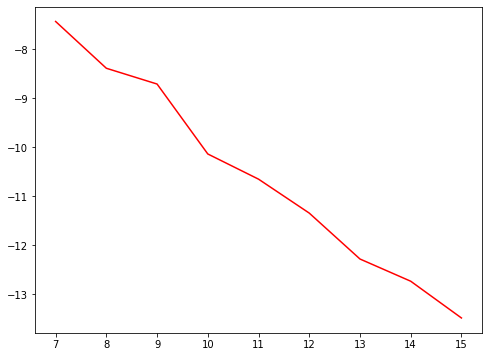

In [ ]:
plt.figure(figsize=(8,6))

plt.plot(np.log2(N_vec),np.log2(error_N_O5_kernel),"r")


The least-square estimate of the slope of the above curve is the following.

In [ ]:
X=np.log2(N_vec).reshape(-1,1)
y=np.log2(error_N_O5_kernel)
reg_Kernal_O5 = LinearRegression().fit(X, y)

print ("The estimate of the slope is", reg_Kernal_O5.coef_)
print ("The estimate of the intercept is", reg_Kernal_O5.intercept_)


The estimate of the slope is [-0.75956076]
The estimate of the intercept is -2.220139281607368


## 2.5 Kernel order = 7 <a class="anchor" id="section2-5"></a>

In [ ]:
error_N_O7_kernel=[]

l_regularity_plus_one=8

for i in tqdm(range(pn)):
    error=np.zeros(NNs)
    for nns in range(NNs):

        density_particle= np.array(pd.read_csv("particle_num_"+str(N_vec[i])+"repeat"+str(nns)+".csv", sep=',',header=None))

        Error_simu_number=1000

        X_simu = np.linspace(0, 6, Error_simu_number)[:, np.newaxis]

        Error_simu_vec=np.zeros(Error_simu_number)
        error_vec=np.zeros(Error_simu_number)

        eta_opt = (N_vec[i])**(-1./(2*l_regularity_plus_one+1))

        for j in range(Error_simu_number):
            Error_simu_vec[j]=kernel_O7_fun((X_simu[j]-density_particle)/eta_opt).sum()/(N_vec[i]*eta_opt)
            error_vec[j]=np.abs(Error_simu_vec[j] - density_true(X_simu[j]))

        error_one=error_vec.max()**2
        error[nns]=error_one

    print ("i=",i,";", "the number of particle is", N_vec[i],";", "The optimal bandwidth is",eta_opt, ".")
    print (i,"the error is :", error.mean())

    error_N_O7_kernel.append(error.mean())

    np.savetxt("error_"+str(i)+"_op_Order_7_kernel.csv", error_N_O7_kernel, delimiter=",")



 11%|█████                                        | 1/9 [00:04<00:33,  4.18s/it]

i= 0 ; the number of particle is 128 ; The optimal bandwidth is 0.7517033269280274 .
0 the error is : 0.0063221259406564595


 22%|██████████                                   | 2/9 [00:08<00:29,  4.15s/it]

i= 1 ; the number of particle is 256 ; The optimal bandwidth is 0.7216702885149783 .
1 the error is : 0.0029841627404436524


 33%|███████████████                              | 3/9 [00:14<00:31,  5.30s/it]

i= 2 ; the number of particle is 512 ; The optimal bandwidth is 0.6928371694903476 .
2 the error is : 0.0023539798400148953


 44%|████████████████████                         | 4/9 [00:20<00:27,  5.58s/it]

i= 3 ; the number of particle is 1024 ; The optimal bandwidth is 0.665156029099061 .
3 the error is : 0.000884987756447753


 56%|█████████████████████████                    | 5/9 [00:28<00:25,  6.28s/it]

i= 4 ; the number of particle is 2048 ; The optimal bandwidth is 0.638580841978044 .
4 the error is : 0.0005852588031082689


 67%|██████████████████████████████               | 6/9 [00:39<00:23,  7.88s/it]

i= 5 ; the number of particle is 4096 ; The optimal bandwidth is 0.6130674216299654 .
5 the error is : 0.00033797704714981605


 78%|███████████████████████████████████          | 7/9 [00:59<00:23, 11.83s/it]

i= 6 ; the number of particle is 8192 ; The optimal bandwidth is 0.5885733469544588 .
6 the error is : 0.000170892567536972


 89%|████████████████████████████████████████     | 8/9 [01:34<00:19, 19.30s/it]

i= 7 ; the number of particle is 16384 ; The optimal bandwidth is 0.5650578917146649 .
7 the error is : 0.00012375116230396062


100%|█████████████████████████████████████████████| 9/9 [02:49<00:00, 18.84s/it]

i= 8 ; the number of particle is 32768 ; The optimal bandwidth is 0.5424819568218185 .
8 the error is : 7.23811662319002e-05


---------------------------------------

The next cell shows the log-log error curve of the density simulation with the Gaussian high order kernel of order 7.

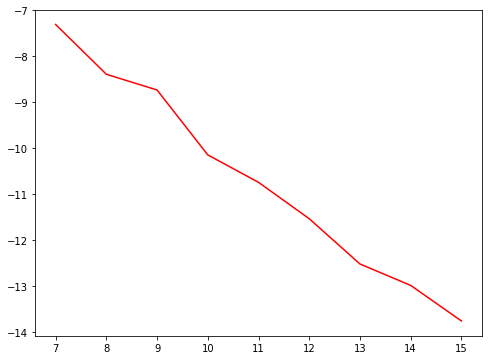

In [ ]:
plt.figure(figsize=(8,6))

plt.plot(np.log2(N_vec),np.log2(error_N_O7_kernel),"r")

The least-square estimate of the slope of the above curve is the following.

In [ ]:
X=np.log2(N_vec).reshape(-1,1)
y=np.log2(error_N_O7_kernel)
reg_Kernal_O7 = LinearRegression().fit(X, y)


print ("The estimate of the slope is", reg_Kernal_O7.coef_)
print ("The estimate of the intercept is", reg_Kernal_O7.intercept_)


The estimate of the slope is [-0.8087776]
The estimate of the intercept is -1.7795478872119617


## 2.6 Kernel order = 9 <a class="anchor" id="section2-6"></a>

In [ ]:
error_N_O9_kernel=[]

l_regularity_plus_one=10

for i in tqdm(range(pn)):
    error=np.zeros(NNs)
    for nns in range(NNs):

        density_particle= np.array(pd.read_csv("particle_num_"+str(N_vec[i])+"repeat"+str(nns)+".csv", sep=',',header=None))

        Error_simu_number=1000

        X_simu = np.linspace(0, 6, Error_simu_number)[:, np.newaxis]

        Error_simu_vec=np.zeros(Error_simu_number)
        error_vec=np.zeros(Error_simu_number)

        eta_opt = (N_vec[i])**(-1./(2*l_regularity_plus_one+1))

        for j in range(Error_simu_number):
            Error_simu_vec[j]=kernel_O9_fun((X_simu[j]-density_particle)/eta_opt).sum()/(N_vec[i]*eta_opt)
            error_vec[j]=np.abs(Error_simu_vec[j] - density_true(X_simu[j]))

        error_one=error_vec.max()**2
        error[nns]=error_one

    print ("i=",i,";", "the number of particle is", N_vec[i],";", "The optimal bandwidth is",eta_opt, ".")
    print (i,"the error is :", error.mean())

    error_N_O9_kernel.append(error.mean())

    np.savetxt("error_"+str(i)+"_op_Order_9_kernel.csv", error_N_O9_kernel, delimiter=",")



 11%|█████                                        | 1/9 [00:06<00:51,  6.47s/it]

i= 0 ; the number of particle is 128 ; The optimal bandwidth is 0.7937005259840998 .
0 the error is : 0.0071010144650967165


 22%|██████████                                   | 2/9 [00:11<00:38,  5.45s/it]

i= 1 ; the number of particle is 256 ; The optimal bandwidth is 0.7679304815207443 .
1 the error is : 0.0031424243665716177


 33%|███████████████                              | 3/9 [00:16<00:31,  5.32s/it]

i= 2 ; the number of particle is 512 ; The optimal bandwidth is 0.7429971445684742 .
2 the error is : 0.0024306920789473737


 44%|████████████████████                         | 4/9 [00:27<00:37,  7.44s/it]

i= 3 ; the number of particle is 1024 ; The optimal bandwidth is 0.7188733487225089 .
3 the error is : 0.0009257224772448806


 56%|█████████████████████████                    | 5/9 [00:40<00:38,  9.66s/it]

i= 4 ; the number of particle is 2048 ; The optimal bandwidth is 0.6955328096229147 .
4 the error is : 0.0005915899646932211


 67%|██████████████████████████████               | 6/9 [01:00<00:39, 13.18s/it]

i= 5 ; the number of particle is 4096 ; The optimal bandwidth is 0.6729500963161781 .
5 the error is : 0.0003203818904257153


 78%|███████████████████████████████████          | 7/9 [01:33<00:38, 19.45s/it]

i= 6 ; the number of particle is 8192 ; The optimal bandwidth is 0.6511006035466159 .
6 the error is : 0.00015988575549228182


 89%|████████████████████████████████████████     | 8/9 [02:26<00:30, 30.38s/it]

i= 7 ; the number of particle is 16384 ; The optimal bandwidth is 0.6299605249474366 .
7 the error is : 0.00011173780622701292


100%|█████████████████████████████████████████████| 9/9 [04:06<00:00, 27.40s/it]

i= 8 ; the number of particle is 32768 ; The optimal bandwidth is 0.6095068271022377 .
8 the error is : 6.284051872881438e-05


---------------------------------------


The next cell shows the log-log error curve of the density simulation with the Gaussian high order kernel of order 9.

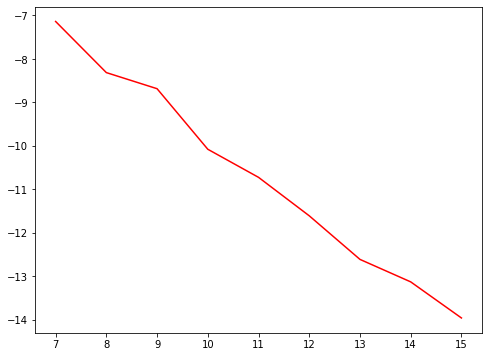

In [ ]:
plt.figure(figsize=(8,6))

plt.plot(np.log2(N_vec),np.log2(error_N_O9_kernel),"r")


The least-square estimate of the slope of the above curve is the following.

In [ ]:
X=np.log2(N_vec).reshape(-1,1)
y=np.log2(error_N_O9_kernel)
reg_Kernal_O9 = LinearRegression().fit(X, y)


print ("The estimate of the slope is", reg_Kernal_O9.coef_)
print ("The estimate of the intercept is", reg_Kernal_O9.intercept_)


The estimate of the slope is [-0.85175177]
The estimate of the intercept is -1.3241151433238656


## 2.7 Comparison of simulation results with different kernels <a class="anchor" id="section2-7"></a>

The next cell shows the log-log error curves of the density simulation with different Gaussian high order kernels for $l=1$ (purple), $l=3$ (blue), $l=5$ (red), $l=7$ (orange), $l=9$ (green).

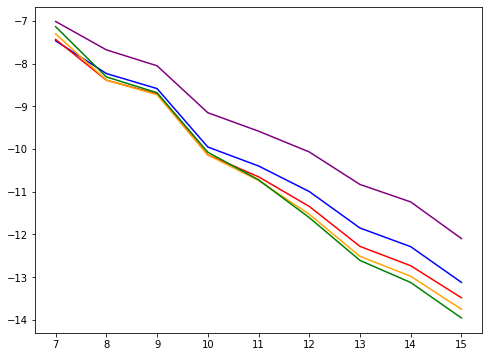

In [ ]:
plt.figure(figsize = (8,6))
plt.plot(np.log2(N_vec), np.log2(error_N_Gaussian_kernel),"purple") # Order 1
plt.plot(np.log2(N_vec), np.log2(error_N_O3_kernel),"b") # Order 3
plt.plot(np.log2(N_vec), np.log2(error_N_O5_kernel),"r") # Order 5
plt.plot(np.log2(N_vec), np.log2(error_N_O7_kernel),"orange") # Order 7
plt.plot(np.log2(N_vec), np.log2(error_N_O9_kernel),"green") # Order 9
plt.savefig('strong_error.png')

The next cell shows the slopes $a_l$ of the above figure as a function of the kernal order $l$.

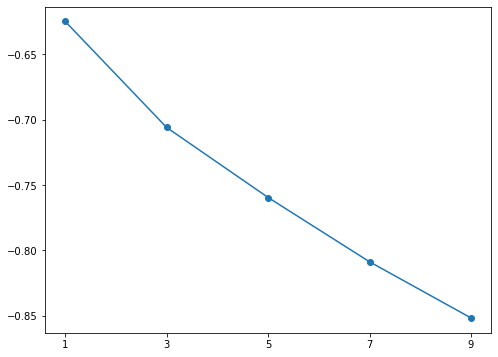

In [ ]:
slope_vec=np.array([reg_Gaussian.coef_,reg_Kernal_O3.coef_,reg_Kernal_O5.coef_,reg_Kernal_O7.coef_,reg_Kernal_O9.coef_])

plt.figure(figsize = (8,6))
plt.plot(np.array([1,3,5,7,9]),slope_vec,"o-")
plt.xticks([1,3,5,7,9])
plt.savefig('strong_error_slope.png')
#plt.xlabel("Order of Gaussian Kernel")
#plt.ylabel("Slope of the log-log error")
